## Dependencies 

In [1]:
# Import dependencies
from sklearn import model_selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import seaborn as sns
from math import sqrt

from yellowbrick.regressor import residuals_plot, prediction_error 
from scipy.stats import randint as sp_randint



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import password

In [2]:
# Database dependencies
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

# Database credentials
DATABASES = {
    'finalproject':{
        'POSTGRES_ADDRESS' :'finalproject.c969jxlkzz2v.us-east-2.rds.amazonaws.com',
        'POSTGRES_PORT' : '5432',
        'POSTGRES_USERNAME' : "postgres",
        'POSTGRES_PASSWORD' : password,
        'POSTGRES_DBNAME' : 'housingdata',
    },
}

# Choose the database to use
db = DATABASES['finalproject']

# Connect to postgres
postgres_str = ('postgresql+psycopg2://{username}:{password}@{ipaddress}:{port}/{dbname}'
               .format(username= db['POSTGRES_USERNAME'],
                      password= db['POSTGRES_PASSWORD'],
                      ipaddress= db['POSTGRES_ADDRESS'],
                      port= db['POSTGRES_PORT'],
                      dbname= db['POSTGRES_DBNAME'])
               )

# Create an database engine instance
connection = create_engine(postgres_str)

## Load the datasets

In [3]:
df = pd.read_sql_table('final_table', connection)
df.head()

,city,zhvi,total_pop,med_income,med_age,male,female,race_w,race_aa,race_nat,...,murder_mansl,rape,robbery,agg_assault,burglary,lar_theft,car_theft,arson,lat,long
0,Ladd,86540.17,1185.0,65972.0,42.9,587.0,598.0,1133.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,41.382535,-89.218975
1,Lake Bluff,459437.17,10003.0,107039.0,42.7,4642.0,5361.0,8616.0,151.0,62.0,...,0.0,0.0,1.0,0.0,7.0,36.0,0.0,0.0,42.278912,-87.834236
2,Lake Forest,808297.42,21131.0,171913.0,46.6,10472.0,10659.0,18890.0,520.0,94.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.258634,-87.840625
3,Lake Villa,208693.58,35286.0,96024.0,40.3,17646.0,17640.0,32294.0,900.0,131.0,...,1.0,4.0,0.0,4.0,3.0,29.0,1.0,0.0,42.416965,-88.073971
4,Lake Zurich,429947.17,42637.0,135146.0,42.0,21299.0,21338.0,36357.0,1008.0,145.0,...,0.0,1.0,1.0,3.0,18.0,238.0,3.0,0.0,42.196969,-88.093411


## Feature Engineering

In [4]:
clean_df = df.drop(['city','lat','long', 'male','female', 'eth_nonhisp','murder_mansl', 'robbery','arson','rape', 'car_theft','rape'],1)
clean_df.head()

,zhvi,total_pop,med_income,med_age,race_w,race_aa,race_nat,race_as,race_api,race_oth,eth_hisp,agg_assault,burglary,lar_theft
0,86540.17,1185.0,65972.0,42.9,1133.0,0.0,0.0,7.0,0.0,49.0,83.0,3.0,0.0,2.0
1,459437.17,10003.0,107039.0,42.7,8616.0,151.0,62.0,1207.0,0.0,129.0,762.0,0.0,7.0,36.0
2,808297.42,21131.0,171913.0,46.6,18890.0,520.0,94.0,1836.0,7.0,142.0,1013.0,0.0,0.0,0.0
3,208693.58,35286.0,96024.0,40.3,32294.0,900.0,131.0,1733.0,17.0,858.0,3137.0,4.0,3.0,29.0
4,429947.17,42637.0,135146.0,42.0,36357.0,1008.0,145.0,5008.0,124.0,868.0,3441.0,3.0,18.0,238.0


In [5]:
clean_df.describe()

,zhvi,total_pop,med_income,med_age,race_w,race_aa,race_nat,race_as,race_api,race_oth,eth_hisp,agg_assault,burglary,lar_theft
count,9.790000e+02,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000,979.00000,979.000000,979.000000,979.000000,979.000000,979.000000,979.000000
mean,1.374120e+05,7628.810429,62588.514917,42.351034,6170.608401,772.398683,53.678888,422.29714,8.344211,385.104208,1054.550669,25.935649,28.830439,149.924413
std,1.178790e+05,11587.889998,21145.745980,5.858168,8906.665564,2649.138961,103.762227,1262.54303,24.359187,1965.207884,3744.702529,493.154123,380.171509,2084.391414
min,1.852242e+04,58.000000,16023.000000,21.500000,58.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.388796e+04,819.500000,49696.000000,38.650000,792.000000,1.000000,0.000000,0.00000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000
50%,9.960942e+04,1995.000000,58289.000000,42.000000,1918.000000,22.000000,9.000000,11.00000,0.000000,8.000000,39.000000,0.000000,0.000000,0.000000
75%,1.601418e+05,9741.500000,70160.000000,45.700000,7515.500000,242.500000,51.500000,121.00000,2.000000,116.000000,481.000000,4.000000,8.000000,31.500000
max,1.360530e+06,83147.000000,212750.000000,63.500000,49654.000000,30695.000000,734.000000,9528.50000,256.000000,47835.000000,74180.000000,15312.000000,11686.000000,64695.000000


## Data Preprocessing

In [6]:
# Split our preprocessed data into our features and target arrays
y = clean_df['zhvi']
X = clean_df.drop(['zhvi'], 1)

In [7]:
# Split and Train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

# Create a StandardScaler instances
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

--------------A Multicollinearity plot---------------


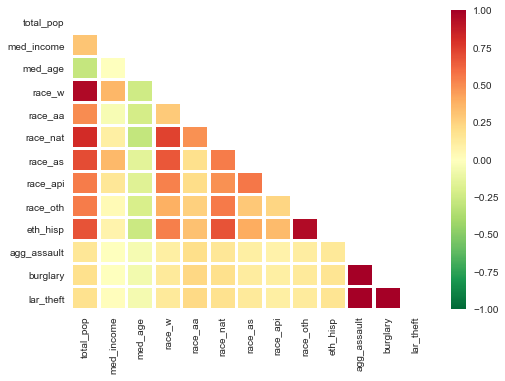

In [8]:
# Check for multicollinearity
corr_df = X.corr(method='pearson')
print("--------------A Multicollinearity plot---------------")

#Create a mask to display only the lower triangle of the matrix(since it mirrored around its top-left to bottom-right diagonal)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

#Create the heatmap using seaborn library
sns.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0, mask= mask, linewidths=2.5)
# Show the plot. We reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

## Linear Regression Models

In [9]:
model_1 = LinearRegression()
model_1.fit(X_train,y_train)
predictions = model_1.predict(X_test)

print(" MAE", mean_absolute_error(y_test,predictions))
print(" RMSE", sqrt(mean_squared_error(y_test,predictions)))
print(" R2", r2_score(y_test, predictions))



 MAE 33203.988282283026
 RMSE 52409.26262287243
 R2 0.7508905264445278


In [10]:
model_2 = KNeighborsRegressor()
model_2.fit(X_train,y_train)
predictions = model_2.predict(X_test)

print(" MAE", mean_absolute_error(y_test,predictions))
print(" RMSE", sqrt(mean_squared_error(y_test,predictions)))
print(" R2", r2_score(y_test, predictions))

 MAE 32951.56553571428
 RMSE 56251.162487599024
 R2 0.713029569544966


In [11]:
model_3 = RandomForestRegressor()
model_3.fit(X_train,y_train)
predictions = model_3.predict(X_test)

print(" MAE", mean_absolute_error(y_test,predictions))
print(" RMSE", sqrt(mean_squared_error(y_test,predictions)))
print(" R2", r2_score(y_test, predictions))

 MAE 26765.404232007568
 RMSE 46782.09690176734
 R2 0.8015123392264576


In [12]:
model_4 = Ridge()
model_4.fit(X_train,y_train)
predictions = model_4.predict(X_test)

print(" MAE", mean_absolute_error(y_test,predictions))
print(" RMSE", sqrt(mean_squared_error(y_test,predictions)))
print(" R2", r2_score(y_test, predictions))

 MAE 33100.91334924512
 RMSE 52349.41955861106
 R2 0.7514590886605582


## Model Selection

OLS: 0.675 (0.084)
KNeigbors: 0.758 (0.072)
Random Forest: 0.816 (0.077)
Ridge: 0.678 (0.080)


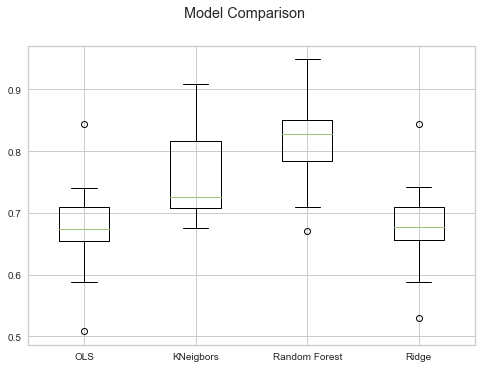

In [13]:
# prepare configuration for cross validation test harness

# prepare models
models = []
models.append(('OLS', LinearRegression()))
models.append(('KNeigbors', KNeighborsRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('Ridge', Ridge()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Random Forest Regressor

In [14]:
## Train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [15]:
# Search for the best params
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, X_train.shape[1]),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}

random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=10, cv=5, iid=False, random_state=42)
best_model = random_search.fit(X_train, y_train)
print(random_search.best_params_)

y_preds = best_model.predict(X_test)
print(r2_score(y_test, y_preds))

/Users/jacob/opt/anaconda3/envs/PythonData/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'bootstrap': True, 'max_depth': None, 'max_features': 9, 'min_samples_split': 4, 'n_estimators': 406}
0.836397928797894


## Prediction and Model Evaluation

In [16]:
# Predict
y_preds = random_search.predict(X_test)

In [17]:
results = pd.DataFrame({"Prediction": y_preds, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,92093.144459,83739.500000
1,139689.897010,131423.580000
2,163870.008611,162155.670000
3,76990.890586,91324.080000
4,69512.074465,81336.580000
5,103817.233722,136188.750000
6,88465.069851,88259.580000
7,242275.921895,229937.303333
8,78591.441775,52089.750000
9,81377.928232,111396.250000


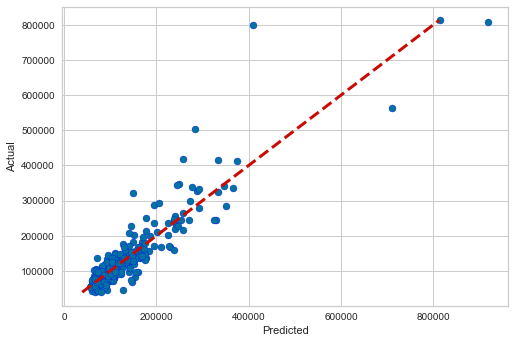

In [18]:
fig, ax = plt.subplots()
ax.scatter(y_preds, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [19]:
# Evaluate the model
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

Mean Absolute Error: 25102.243576106604
Root Mean Squared Error: 42472.451217310074


Text(0.5, 0, 'Random Forest Feature Importance')

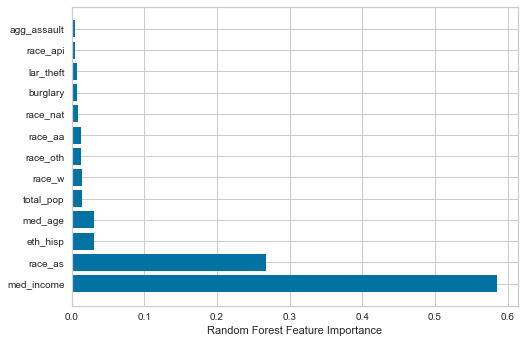

In [20]:
# List the features sorted in descending order by feature importance
features = (sorted(zip(model.feature_importances_, X.columns), reverse=True))

vals = [f for f,x in features]
names = [x for f,x in features]

plt.barh(names, vals)
plt.xlabel("Random Forest Feature Importance")

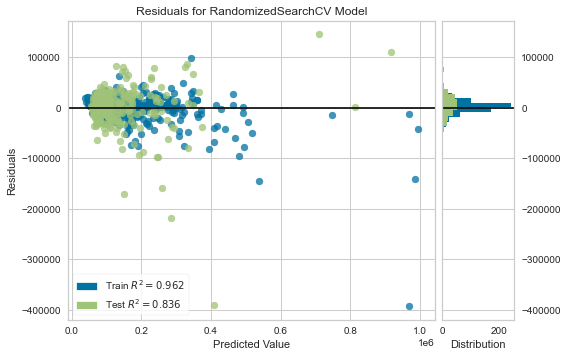

In [21]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(best_model, X_train, y_train, X_test, y_test)

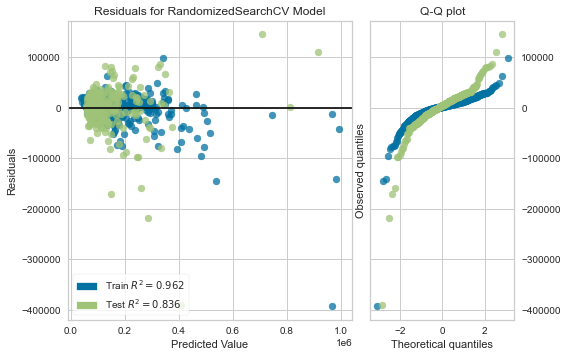

In [22]:
viz = residuals_plot(best_model,X_train, y_train, X_test, y_test,hist=False, qqplot=True)


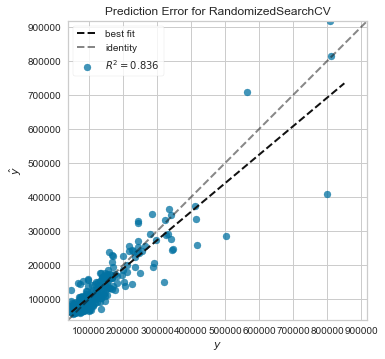

In [23]:
# Instantiate the linear model and visualizer
visualizer = prediction_error(best_model, X_train, y_train, X_test, y_test)